<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.CrowdCounting/blob/main/2_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod
import pandas as pd

from keras import backend as K
from keras.utils.layer_utils import count_params

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import (
    Dense,
    Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# PEP8 standard

In [ ]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

# Custom packages

In [ ]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [ ]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager

# Setup paths

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/7.CrowdCounting/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Models/trial_1 already exists


# Helper functions

In [ ]:
def save_history(history, target_path_):
    # assert os.path.isdir(target_path_)
    df = pd.DataFrame(history.history)
    df.to_csv(target_path_)


pep8(_ih)

In [ ]:
def plot_history(history_, metrics_):
    _, ax = plt.subplots()
    ax.plot(history_.history[metrics_], label='train')
    ax.plot(history_.history[f'val_{metrics_}'], label='validation')
    ax.grid()
    ax.legend(shadow=True)


pep8(_ih)

In [ ]:
def count_parameters(model):
    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)

    return {
        'Total parameters': trainable_count + non_trainable_count,
        'Trainable parameters': trainable_count,
        'Non-trainable parameters': non_trainable_count
     }


pep8(_ih)

In [ ]:
def visualize_predictions(
    model_,
    generator_
):
        X_batch, Y_batch = next(generator_)
        print(X_batch.shape, np.max(X_batch), np.min(X_batch))

        predictions = model_.predict(X_batch)
        print(type(predictions), predictions.shape)

        _, ax = plt.subplots(3, 3, figsize=(10, 10))
        ax = ax.flatten()
        for i in range(9):
            ax[i].imshow(X_batch[i])
            ax[i].set_title(f'Ground truth: {Y_batch[i]}\nPredicted: {predictions[i]}')
            ax[i].axis('off')

        fontsize = 14
        labelsize = 12
        legendsize = 13

        _, ax_hist = plt.subplots()
        ax_hist.hist(Y_batch, label='Ground truth labels', alpha=0.5)
        ax_hist.hist(predictions, label='Model predictions', alpha=0.5),
        ax_hist.legend(prop={'size': legendsize})
        ax_hist.set_title(f'Distribution of predictions', fontsize=fontsize)
        ax_hist.set_xlabel('Predicted quantities', fontsize=fontsize)
        ax_hist.set_ylabel(f'Count', fontsize=fontsize)
        ax_hist.grid()

        _, ax_predictions = plt.subplots()
        ax_predictions.plot(
            Y_batch,
            predictions,
            linestyle='None',
            marker='o',
            # markerfacecolor='white',
            markersize=3
        )

        min_val = min(np.min(Y_batch), np.min(predictions))
        max_val = max(np.max(Y_batch), np.max(predictions))
        ax_predictions.plot(
            np.arange(int(min_val), int(max_val)),
            np.arange(int(min_val), int(max_val)),
            label='Perfect match'
        )


        ax_predictions.set_xlabel('Ground truth', fontsize=fontsize)
        ax_predictions.set_ylabel('Predicted values', fontsize=fontsize)
        ax_predictions.grid()
        ax_predictions.tick_params(labelsize=labelsize)
        ax_predictions.legend(shadow=True, prop={'size':legendsize})

# Data split

In [ ]:
frames_directory = os.path.join(manager.data_root_path, 'frames')
labels_df = pd.read_csv(os.path.join(manager.data_root_path, 'labels.csv'))
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
print(labels_df.head(1))

   id  count      image_name
0   1     35  seq_000001.jpg


In [ ]:
TRAINVAL_SIZE = 0.8
RANDOM_STATE = 42

trainval_labels_df, test_labels_df = train_test_split(
    labels_df,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
)
trainval_labels_df.shape, test_labels_df.shape

((1600, 3), (400, 3))

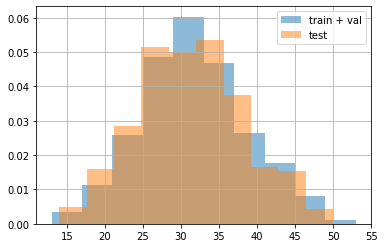

In [ ]:
_, ax = plt.subplots()
ax.hist(trainval_labels_df['count'], density=True, label='train + val', alpha=0.5)
ax.hist(test_labels_df['count'], density=True, label='test', alpha=0.5)
ax.grid()
ax.legend()

# Define the model

In [ ]:
class NNModel(ABC):
    def __init__(
        self,
        name_,
        input_image_size_,
        validation_split_,
        batch_size_,
        trainval_labels_df_,
        test_labels_df_,
        frames_directory_=frames_directory
    ):
        self.random_state = 42
        self.name = name_
        self.input_image_size = input_image_size_
        self.validation_split = validation_split_
        self.batch_size = batch_size_
        self.frames_directory = frames_directory_

        self.data_generator_parameters = None
        self.train_generator = None
        self.validation_generator = None
        self.test_generator = None
        self.model = None
        self.init_data_generator_parameters()
        self.init_data_generators(
            trainval_labels_df_,
            test_labels_df_
        )

    def __repr__(self):
        return f'''
            {
                self.random_state,
                self.name,
                self.input_image_size,
                self.validation_split,
                self.batch_size
            }
        '''

    @abstractmethod
    def init_data_generator_parameters(self):
        # Augmentation / preprocessing parameters
        pass

    def init_data_generators(
        self,
        trainval_labels_df_,
        test_labels_df_
    ):
        trainval_data_generator = ImageDataGenerator(
            **self.data_generator_parameters,
            validation_split=self.validation_split)

        test_data_generator = ImageDataGenerator(
            **self.data_generator_parameters)

        common_flow_params = dict(
            directory=self.frames_directory,
            x_col='image_name',
            y_col='count',
            target_size=self.input_image_size,
            color_mode='rgb',
            class_mode='raw',
            batch_size=self.batch_size,
            shuffle=True,
            seed=self.random_state
        )

        self.train_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='training',
            dataframe=trainval_labels_df_
        )

        self.validation_generator = trainval_data_generator.\
            flow_from_dataframe(
                **common_flow_params,
                subset='validation',
                dataframe=trainval_labels_df_
            )

        self.test_generator = test_data_generator.flow_from_dataframe(
            **common_flow_params,
            dataframe=test_labels_df_
        )

    def visualize_data(self):
        X_batch, Y_batch = next(self.train_generator)
        print(X_batch.shape, np.max(X_batch), np.min(X_batch))

        _, ax = plt.subplots(3, 3, figsize=(10, 10))
        ax = ax.flatten()
        for i in range(9):
            ax[i].imshow(X_batch[i])
            ax[i].set_title(Y_batch[i])
            ax[i].axis('off')

        _, ax_hist = plt.subplots()
        ax_hist.hist(Y_batch)

    @abstractmethod
    def prepare_model(self):
        pass

    def compile_model(
        self,
        optimizer_=tf.keras.optimizers.Adam(learning_rate=0.001)
    ):
        self.model.compile(
            optimizer=optimizer_,
            # tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mse', 'mae']
        )

    def unfreeze_n_layers(self, n_layers_to_freeze_):
        assert n_layers_to_freeze_ > 0

        for layer in self.model.layers[:-n_layers_to_freeze_]:
            layer.trainable = False
        for layer in self.model.layers[-n_layers_to_freeze_:]:
            layer.trainable = True

    def fit(self, epochs_, callbacks_):
        self.learning_history = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        return self.learning_history


pep8(_ih)

In [ ]:
class XceptionModelGeronExperiment(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.xception.preprocess_input,
            # horizontal_flip=True
        )
    
    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=500, activation='elu')(x)
        # x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        # x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='relu', kernel_initializer='he_normal')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )
    
    def fit(
        self,
        epochs_,
        epochs_initial_,
        callbacks_,
        n_unfreeze_initial_,
        n_unfreeze_final_,
        optimizer_initial_=tf.keras.optimizers.Adam(learning_rate=0.001),
        optimizer_final_=tf.keras.optimizers.Adam(learning_rate=0.0005)
    ):
        print(f'Running custom fit')
        print(f'Unfreezing {n_unfreeze_initial_} layers')
        self.unfreeze_n_layers(n_unfreeze_initial_)
        self.compile_model(optimizer_=optimizer_initial_)

        history_initial = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_initial_,
            callbacks=[]
        )

        print(f'Unfreezing {n_unfreeze_final_} layers')
        self.unfreeze_n_layers(n_unfreeze_final_)
        self.compile_model(optimizer_=optimizer_final_)

        self.learning_history = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        return self.learning_history

In [ ]:
xception_demo = XceptionModelGeronExperiment(
    name_='xception_demo',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=32,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


# Train the model

In [ ]:
xception_demo.prepare_model()


history_demo = xception_demo.fit(
    epochs_=40,
    epochs_initial_=6,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=5
        ),
        ReduceLROnPlateau(
        monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                xception_demo.name,
                xception_demo.name
            ),
            save_weights_only=True,
        )
    ],
    n_unfreeze_initial_=7,
    n_unfreeze_final_=17,
    optimizer_initial_=tf.keras.optimizers.Adam(learning_rate=0.001),
    optimizer_final_=tf.keras.optimizers.Adam(learning_rate=0.0004)
)

83683744/83683744 [==============================] - 4s 0us/step
Running custom fit
Unfreezing 7 layers


<ipython-input-24-97781e240cd0>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_initial = self.model.fit_generator(


Epoch 1/6
40/40 [==============================] - 1028s 26s/step - loss: 110.0916 - mse: 110.0916 - mae: 7.9535 - val_loss: 33.8854 - val_mse: 33.8854 - val_mae: 4.6643
Epoch 2/6
40/40 [==============================] - 15s 361ms/step - loss: 32.3422 - mse: 32.3422 - mae: 4.5065 - val_loss: 26.2056 - val_mse: 26.2056 - val_mae: 3.9436
Epoch 3/6
40/40 [==============================] - 15s 380ms/step - loss: 24.9576 - mse: 24.9576 - mae: 4.0176 - val_loss: 23.8818 - val_mse: 23.8818 - val_mae: 3.7914
Epoch 4/6
40/40 [==============================] - 16s 385ms/step - loss: 21.7221 - mse: 21.7221 - mae: 3.6335 - val_loss: 26.6573 - val_mse: 26.6573 - val_mae: 4.1087
Epoch 5/6
40/40 [==============================] - 15s 368ms/step - loss: 18.6883 - mse: 18.6883 - mae: 3.4200 - val_loss: 11.4448 - val_mse: 11.4448 - val_mae: 2.6822
Epoch 6/6
40/40 [==============================] - 15s 366ms/step - loss: 15.2987 - mse: 15.2987 - mae: 3.0925 - val_loss: 11.0826 - val_mse: 11.0826 - val_ma

<ipython-input-24-97781e240cd0>:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/40
40/40 [==============================] - 21s 440ms/step - loss: 21.4165 - mse: 21.4165 - mae: 3.5401 - val_loss: 14.2440 - val_mse: 14.2440 - val_mae: 2.9637 - lr: 4.0000e-04
Epoch 2/40
40/40 [==============================] - 17s 425ms/step - loss: 11.1163 - mse: 11.1163 - mae: 2.6417 - val_loss: 32.9803 - val_mse: 32.9803 - val_mae: 4.7742 - lr: 4.0000e-04
Epoch 3/40
40/40 [==============================] - 18s 440ms/step - loss: 8.4084 - mse: 8.4084 - mae: 2.2885 - val_loss: 10.0337 - val_mse: 10.0337 - val_mae: 2.5980 - lr: 4.0000e-04
Epoch 4/40
40/40 [==============================] - 17s 418ms/step - loss: 7.0365 - mse: 7.0365 - mae: 2.0956 - val_loss: 20.0141 - val_mse: 20.0141 - val_mae: 3.5653 - lr: 4.0000e-04
Epoch 5/40
40/40 [==============================] - 16s 408ms/step - loss: 6.3152 - mse: 6.3152 - mae: 1.9560 - val_loss: 10.4382 - val_mse: 10.4382 - val_mae: 2.6167 - lr: 4.0000e-04
Epoch 6/40
40/40 [==============================] - 16s 408ms/step - loss: 9

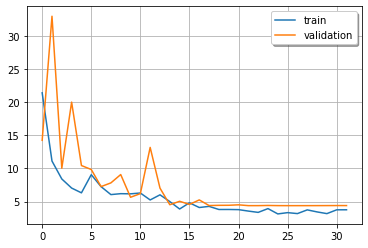

In [ ]:
plot_history(history_demo, metrics_='loss')

In [ ]:
save_history(
    history_demo,
    os.path.join(
        manager.models_trial_path,
        f'{xception_demo.name}.csv'
    )
)

# Analyze the model

In [ ]:
xception_demo.model.evaluate(
    xception_demo.validation_generator
)

10/10 [==============================] - 3s 273ms/step - loss: 4.3928 - mse: 4.3928 - mae: 1.6319


[4.392812252044678, 4.392812252044678, 1.631856918334961]

In [ ]:
xception_demo.model.evaluate(
    xception_demo.test_generator
)

13/13 [==============================] - 236s 20s/step - loss: 4.5568 - mse: 4.5568 - mae: 1.6440


[4.556783199310303, 4.556783199310303, 1.6440272331237793]

(32, 299, 299, 3) 1.0 -1.0
1/1 [==============================] - 0s 35ms/step


<class 'numpy.ndarray'> (32, 1)


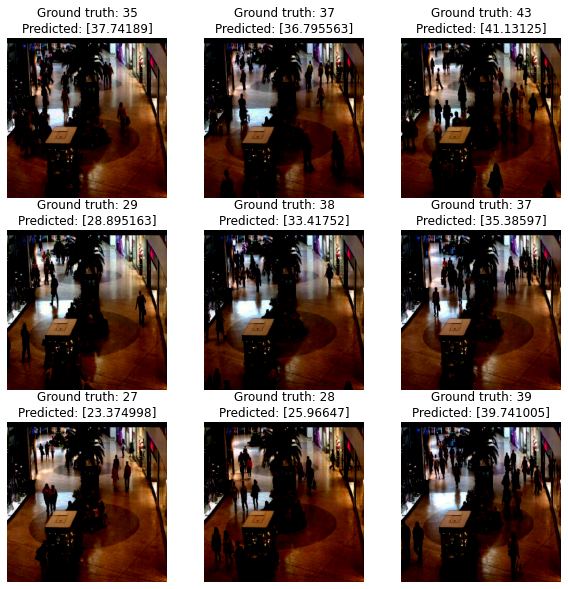

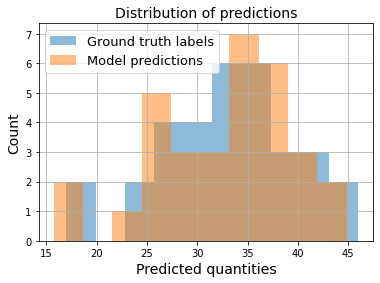

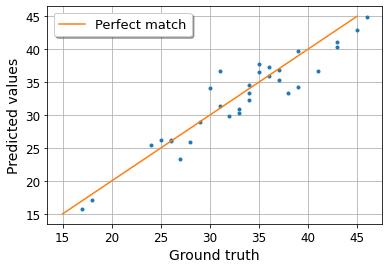

In [ ]:
visualize_predictions(
    xception_demo.model,
    xception_demo.validation_generator
)

(32, 299, 299, 3) 1.0 -1.0
1/1 [==============================] - 0s 37ms/step
<class 'numpy.ndarray'> (32, 1)


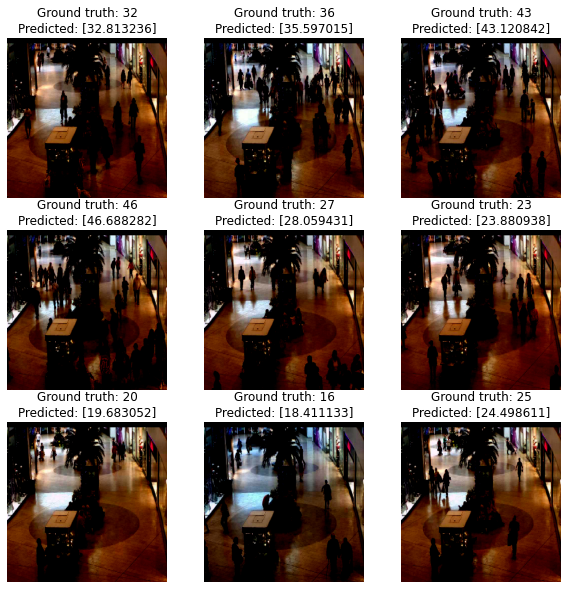

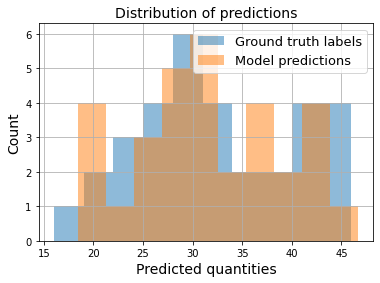

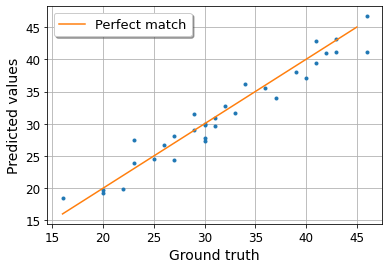

In [ ]:
visualize_predictions(
    xception_demo.model,
    xception_demo.test_generator
)